will later move this into function script

In [1]:
import pandas as pd
import re

In [2]:
df = pd.read_csv('results/controlled_results.csv')
columns = list(df.columns)
for col in columns:
    print(col)

global_energy_metrics_local_process_results_gpu_power_process_3
compute_metrics_compute_utilisation_gpu_utilization_percent_1
variables_decoder_config_decoder_top_k
variables_quantisation_load_in_8bit
global_energy_metrics_per-process_emissions_2
global_energy_metrics_local_process_results_total_energy_joules_process_2
compute_metrics_compute_utilisation_gpu_utilization_percent_2
variables_backend
global_energy_metrics_local_process_results_total_energy_kwh_process_2
global_energy_metrics_global_derived_quantities_flops_per_joule
variables_max_output_tokens
variables_batching_options_adaptive_batching
global_energy_metrics_local_process_results_ram_energy_process_2
global_energy_metrics_local_process_results_ram_power_process_0
setup_country
setup_available_gpu_count
variables_latency_simulation_simulate
setup_is_encoder_decoder
model_architecture_architecture
global_energy_metrics_local_process_results_cpu_power_process_3
inference_metrics_inference_performance_total_inference_time_se

In [3]:
def clean_column(col: str) -> str:
    """
    Clean a single column name by:
      - Stripping whitespace and replacing any non-standard quotes.
      - Checking for per-process metric patterns.
      - Applying special renames.
      - Removing the 'variables_' prefix if present.
      - Otherwise, attempting to strip off any messy prefixes using a known list of tokens.
    
    If no known token is found, the original (normalized) column name is returned.
    """
    # Normalize the column string: remove extra whitespace and fix common issues with quotes.
    col = col.strip()
    col = col.replace("“", "\"").replace("”", "\"")
    
    # 1. Special exact mappings.
    special_mappings = {
        "setup_cpu_model": "cpu_model",
        "setup_gpu_model": "gpu_model",
        "model_architecture_total_params": "total_params",  # now maps to total_params
        "model_architecture_architecture": "model_arch"
    }
    if col in special_mappings:
        return special_mappings[col]
    
    # 2. Remove the 'variables_' prefix if it exists.
    if col.startswith("variables_"):
        col = col[len("variables_"):]
    
    # 3. First, check if it is a per-process metric column.
    per_process_patterns = [
        r'(cpu_power_process_\d+)',
        r'(gpu_power_process_\d+)',
        r'(ram_power_process_\d+)',
        r'(cpu_energy_process_\d+)',
        r'(gpu_energy_process_\d+)',
        r'(ram_energy_process_\d+)',
        r'(total_energy_kwh_process_\d+)',
        r'(total_energy_joules_process_\d+)'
    ]
    for pattern in per_process_patterns:
        match = re.search(pattern, col)
        if match:
            return match.group(1)
    
    # 4. For non-per-process columns, search for a known token in the cleaned column.
    tokens = [
        "config_name", "experiment_id", "date_time", "model", "is_encoder_decoder",
        "task_type", "available_gpu_count", "gpu_model", "available_cpu_count", "cpu_model",
        "os", "python_version", "country", "region", "fsdp_use_orig_params", "fsdp_cpu_offload",
        "sharding_strategy", "distributed_type", "num_processes", "max_input_tokens", "max_output_tokens",
        "number_input_prompts", "decode_token_to_text", "decoder_temperature", "decoder_top_k", "decoder_top_p",
        "query_rate", "latency_simulate", "latency_delay_min", "latency_delay_max", "latency_simulate_burst",
        "latency_burst_interval", "latency_burst_size", "fp_precision", "quantization", "load_in_8bit",
        "load_in_4bit", "cached_flops_for_quantised_models", "batch_size___fixed_batching", "adaptive_batching",
        "adaptive_max_tokens", "max_batch_size___adaptive_batching", "inference_type", "backend", "total_params",
        "architecture", "total_input_tokens", "total_generated_tokens", "total_inference_time_sec", 
        "average_latency_ms_per_batch", "throughput_queries_per_sec", "throughput_tokens_per_sec", "flops",
        "gpu_current_memory_allocated_bytes", "gpu_max_memory_allocated_bytes", "gpu_current_memory_reserved_bytes",
        "gpu_max_memory_reserved_bytes", "gpu_utilization_percent", "cpu_usage_percent", "cpu_memory_usage_bytes",
        # Per-process metrics:
        "cpu_power_process_0", "gpu_power_process_0", "ram_power_process_0",
        "cpu_energy_process_0", "gpu_energy_process_0", "ram_energy_process_0",
        "total_energy_kwh_process_0", "total_energy_joules_process_0",
        # Global averages and totals:
        "cpu_power_avg", "gpu_power_avg", "ram_power_avg", "cpu_energy_total", "gpu_energy_total", "ram_energy_total",
        "total_energy_kwh", "total_energy_joules", "tokens_per_joule", "joules_per_token", "flops_per_joule", "joules_per_flop",
        "per-process_emissions"
    ]
    
    for token in tokens:
        if token in col:
            idx = col.find(token)
            return col[idx:]
    
    return col

def resolve_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resolve duplicate columns in the DataFrame.
    
    For any column that appears more than once:
      - For 'adaptive_batching', if duplicates exist, prefer the one with a boolean dtype;
        otherwise, pick the first occurrence.
      - For all other columns (including 'experiment_id' and 'number_input_prompts'),
        keep only the first occurrence.
    """
    # Build a mapping of column name to list of indices where it occurs.
    seen = {}
    for idx, col in enumerate(df.columns):
        seen.setdefault(col, []).append(idx)
    
    # Choose one index per duplicate group.
    chosen_indices = []
    for col, indices in seen.items():
        if len(indices) == 1:
            chosen_indices.append(indices[0])
        else:
            if col == "adaptive_batching":
                # Look for a column with boolean type.
                bool_idx = None
                for i in indices:
                    if pd.api.types.is_bool_dtype(df.iloc[:, i]):
                        bool_idx = i
                        break
                chosen_indices.append(bool_idx if bool_idx is not None else indices[0])
            else:
                # For experiment_id, number_input_prompts, or any duplicate, keep the first occurrence.
                chosen_indices.append(indices[0])
    
    # Sort indices to preserve the original order.
    chosen_indices.sort()
    return df.iloc[:, chosen_indices]

def clean_and_reorder_columns(df: pd.DataFrame, desired_order: list) -> pd.DataFrame:
    """
    Clean DataFrame columns by:
      1. Renaming each column to remove extraneous prefixes and apply special mappings.
      2. Removing duplicates (applying special resolution for some columns).
      3. Reordering columns into the order specified by 'desired_order'. Any columns not explicitly mentioned
         will be appended at the end.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with messy, flattened column names.
        desired_order (list): List of column names (after cleaning) indicating the preferred ordering.
        
    Returns:
        pd.DataFrame: DataFrame with cleaned and reordered columns.
    """
    # Build mapping from original column names to cleaned names.
    mapping = {col: clean_column(col) for col in df.columns}
    
    # Rename columns in the DataFrame.
    df = df.rename(columns=mapping)
    
    # Resolve duplicates as required.
    df = resolve_duplicates(df)
    
    # Reorder columns: first, the ones matching the desired order.
    ordered_cols = [col for col in desired_order if col in df.columns]
    # Then, append any remaining columns.
    remaining_cols = [col for col in df.columns if col not in desired_order]
    final_order = ordered_cols + remaining_cols
    
    return df[final_order]

# Example desired order list
desired_order = [
    "config_name",
    "experiment_id",
    "date_time",
    "model",
    # num_process
    "num_processes",
    # batching
    "batch_size___fixed_batching",
    # decodeer
    "decoder_temperature",
    "decoder_top_k",
    "decoder_top_p",
    # latency
    "latency_simulation_simulate"
    "latency_simulation_delay_max",
    "latency_simulation_delay_min",
    "latency_simulation_simulate_burst",
    "latency_simulation_burst_size",
    "latency_simulation_burst_interval",
    # precision / quantisation
    "fp_precision",
    "quantization",
    "load_in_8bit",
    "load_in_4bit",
    "cached_flops_for_quantised_models",
    
    # UNUSED PARAMS
    "sharding_strategy",
    "sharding_config_fsdp_config_use_orig_params",
    "sharding_config_fsdp_config_cpu_offload",
    "adaptive_batching",
    "adaptive_max_tokens",
    "query_rate",
    "total_input_tokens",
    "total_generated_tokens"
    
    # CONSTANT SETUP ====
    "date_time",
    "is_encoder_decoder",
    "task_type",
    "available_gpu_count",
    "gpu_model",
    "available_cpu_count",
    "cpu_model",
    "os",
    "python_version",
    "country",
    "region",
    "distributed_type",
    "decode_token_to_text",
    "inference_type",
    "backend",
    "total_params",
    "model_arch",

    # Validation (should be same):
    "max_input_tokens",
    "max_output_tokens",
    "number_input_prompts",
    
    # RESULTS =====
    # energy
    "total_energy_kwh",
    "total_energy_joules",
    # FLOPS
    "flops",
    "tokens_per_joule",
    "joules_per_token",
    "flops_per_joule",
    "joules_per_flop",
    "total_inference_time_sec", 
    # inference performance
    "average_latency_ms_per_batch",
    "throughput_queries_per_sec",
    "throughput_tokens_per_sec",
    # CPU utilization
    "cpu_usage_percent",
    "cpu_memory_usage_bytes",
    # GPU utilization
    "gpu_utilization_percent_0", "gpu_utilization_percent_1", "gpu_utilization_percent_2", "gpu_utilization_percent_3",
    # Compute mem
    "gpu_current_memory_allocated_bytes",
    "gpu_max_memory_allocated_bytes",
    "gpu_current_memory_reserved_bytes",
    "gpu_max_memory_reserved_bytes",
    # Per-process metrics:
    "cpu_power_process_0", "cpu_power_process_1", "cpu_power_process_2", "cpu_power_process_3",
    "gpu_power_process_0", "gpu_power_process_1", "gpu_power_process_2", "gpu_power_process_3",
    "ram_power_process_0", "ram_power_process_1", "ram_power_process_2", "ram_power_process_3",
    "cpu_energy_process_0", "cpu_energy_process_1", "cpu_energy_process_2", "cpu_energy_process_3",
    "gpu_energy_process_0", "gpu_energy_process_1", "gpu_energy_process_2", "gpu_energy_process_3",
    "ram_energy_process_0", "ram_energy_process_1", "ram_energy_process_2", "ram_energy_process_3",
    "total_energy_kwh_process_0", "total_energy_kwh_process_1", "total_energy_kwh_process_2", "total_energy_kwh_process_3",
    "total_energy_joules_process_0", "total_energy_joules_process_1", "total_energy_joules_process_2", "total_energy_joules_process_3",
    # Global averages and totals:
    "cpu_power_avg",
    "gpu_power_avg",
    "ram_power_avg",
    "cpu_energy_total",
    "gpu_energy_total",
    "ram_energy_total",
    # per-process_emsisisons
    "per-process_emissions_0", "per-process_emissions_1", "per-process_emissions_2","per-process_emissions_3"
]


In [4]:
def inspect_results(name, desired_order):
    input_file = f"results/{name}_results.csv"
    
    df = pd.read_csv(input_file)
    df_cleaned = clean_and_reorder_columns(df, desired_order)
    
    return df_cleaned

possible_files = ["controlled", "scenarios", "grid", "text_generation"]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

for file in possible_files:
    try:
        var_name = f"df_{file}_cleaned"
        globals()[var_name] = inspect_results(file, desired_order)  # dynamically create variable
        print(f"Found & inspecting: {var_name}")
        display(globals()[var_name].T)
    except Exception as e:
        print(f"{file} did not exist: {e}")



Found & inspecting: df_controlled_cleaned


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
config_name,num_processes_1,num_processes_2,num_processes_3,num_processes_4,batching_1,batching_2,batching_4,batching_8,batching_16,batching_32,batching_64,precis_float32_quant_False_quant8_False_quant4...,precis_float16_quant_False_quant8_False_quant4...,precis_float16_quant_True_quant8_True_quant4_F...,precis_float16_quant_True_quant8_False_quant4_...,decoding_greedy_decoder_temperature_0,decoding_greedy_decoder_temperature_0.7,decoding_greedy_decoder_temperature_1.0,decoding_greedy_decoder_temperature_1.3,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,latency_False,latency_True_latency_0.05_latency_0.2_latency_...,latency_True_latency_0.2_latency_0.6_latency_F...,latency_True_latency_0.05_latency_0.2_latency_...,latency_True_latency_0.2_latency_0.6_latency_T...
experiment_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
date_time,"April 08, 2025 at 04:31:33 PM","April 08, 2025 at 04:32:06 PM","April 08, 2025 at 04:32:41 PM","April 08, 2025 at 04:33:15 PM","April 08, 2025 at 04:34:12 PM","April 08, 2025 at 04:34:59 PM","April 08, 2025 at 04:35:43 PM","April 08, 2025 at 04:36:20 PM","April 08, 2025 at 04:36:58 PM","April 08, 2025 at 04:37:33 PM","April 08, 2025 at 04:38:19 PM","April 08, 2025 at 04:38:55 PM","April 08, 2025 at 04:39:28 PM","April 08, 2025 at 04:40:33 PM","April 08, 2025 at 04:41:10 PM","April 08, 2025 at 04:41:43 PM","April 08, 2025 at 04:42:19 PM","April 08, 2025 at 04:42:54 PM","April 08, 2025 at 04:43:29 PM","April 08, 2025 at 04:44:03 PM","April 08, 2025 at 04:44:38 PM","April 08, 2025 at 04:45:14 PM","April 08, 2025 at 04:45:49 PM","April 08, 2025 at 04:46:23 PM","April 08, 2025 at 04:47:02 PM","April 08, 2025 at 04:47:37 PM","April 08, 2025 at 04:48:15 PM","April 08, 2025 at 04:48:49 PM","April 08, 2025 at 04:49:27 PM","April 08, 2025 at 04:50:02 PM","April 08, 2025 at 04:50:37 PM","April 08, 2025 at 04:51:12 PM"
model,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0
num_processes,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
batch_size___fixed_batching,16,16,16,16,1,2,4,8,16,32,64,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
decoder_temperature,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.7,1.0,1.3,0.0,0.7,1.0,1.3,0.0,0.7,1.0,1.3,1.0,1.0,1.0,1.0,1.0
decoder_top_k,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50,0,0,0,0,0,0,0,0,0
decoder_top_p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

scenarios did not exist: [Errno 2] No such file or directory: 'results/scenarios_results.csv'
grid did not exist: [Errno 2] No such file or directory: 'results/grid_results.csv'
text_generation did not exist: [Errno 2] No such file or directory: 'results/text_generation_results.csv'


In [5]:
# second round ordering
#existing_cols = [col for col in desired_order if col in df.columns]
#df_controlled = df[existing_cols]

In [6]:
columns_to_drop = [
    "sharding_strategy",
    "sharding_config_fsdp_config_use_orig_params",
    "sharding_config_fsdp_config_cpu_offload",
    "adaptive_batching",
    "adaptive_max_tokens",
    "query_rate",
    "is_encoder_decoder",
    "task_type",
    "available_gpu_count",
    "gpu_model",
    "available_cpu_count",
    "cpu_model",
    "os",
    "python_version",
    "country",
    "region",
    "distributed_type",
    "decode_token_to_text",
    "inference_type",
    "backend",
    "model_arch",
    "gpu_current_memory_allocated_bytes",
    "gpu_max_memory_allocated_bytes",
    "gpu_current_memory_reserved_bytes",
    "gpu_max_memory_reserved_bytes",
    "per-process_emissions_0", "per-process_emissions_1", "per-process_emissions_2","per-process_emissions_3" # OR IS THIS NICE TO HAVE?
]

for file in possible_files:
    try:
        cleaned_var = f"df_{file}_cleaned"   # e.g., df_controlled_cleaned
        dropped_var = f"df_{file}_dropped"     # e.g., df_controlled_dropped
        
        # Drop the specified columns from the cleaned DataFrame.
        globals()[dropped_var] = globals()[cleaned_var].drop(columns=columns_to_drop)
        print(f"Found & inspecting dropped version: {dropped_var}")
        display(globals()[dropped_var].T)
    except Exception as e:
        print(f"Error processing {file}: {e}")

Found & inspecting dropped version: df_controlled_dropped


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
config_name,num_processes_1,num_processes_2,num_processes_3,num_processes_4,batching_1,batching_2,batching_4,batching_8,batching_16,batching_32,batching_64,precis_float32_quant_False_quant8_False_quant4...,precis_float16_quant_False_quant8_False_quant4...,precis_float16_quant_True_quant8_True_quant4_F...,precis_float16_quant_True_quant8_False_quant4_...,decoding_greedy_decoder_temperature_0,decoding_greedy_decoder_temperature_0.7,decoding_greedy_decoder_temperature_1.0,decoding_greedy_decoder_temperature_1.3,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,latency_False,latency_True_latency_0.05_latency_0.2_latency_...,latency_True_latency_0.2_latency_0.6_latency_F...,latency_True_latency_0.05_latency_0.2_latency_...,latency_True_latency_0.2_latency_0.6_latency_T...
experiment_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
date_time,"April 08, 2025 at 04:31:33 PM","April 08, 2025 at 04:32:06 PM","April 08, 2025 at 04:32:41 PM","April 08, 2025 at 04:33:15 PM","April 08, 2025 at 04:34:12 PM","April 08, 2025 at 04:34:59 PM","April 08, 2025 at 04:35:43 PM","April 08, 2025 at 04:36:20 PM","April 08, 2025 at 04:36:58 PM","April 08, 2025 at 04:37:33 PM","April 08, 2025 at 04:38:19 PM","April 08, 2025 at 04:38:55 PM","April 08, 2025 at 04:39:28 PM","April 08, 2025 at 04:40:33 PM","April 08, 2025 at 04:41:10 PM","April 08, 2025 at 04:41:43 PM","April 08, 2025 at 04:42:19 PM","April 08, 2025 at 04:42:54 PM","April 08, 2025 at 04:43:29 PM","April 08, 2025 at 04:44:03 PM","April 08, 2025 at 04:44:38 PM","April 08, 2025 at 04:45:14 PM","April 08, 2025 at 04:45:49 PM","April 08, 2025 at 04:46:23 PM","April 08, 2025 at 04:47:02 PM","April 08, 2025 at 04:47:37 PM","April 08, 2025 at 04:48:15 PM","April 08, 2025 at 04:48:49 PM","April 08, 2025 at 04:49:27 PM","April 08, 2025 at 04:50:02 PM","April 08, 2025 at 04:50:37 PM","April 08, 2025 at 04:51:12 PM"
model,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,TinyLlama/TinyLlama-1.1B-Chat-v1.0
num_processes,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
batch_size___fixed_batching,16,16,16,16,1,2,4,8,16,32,64,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
decoder_temperature,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.7,1.0,1.3,0.0,0.7,1.0,1.3,0.0,0.7,1.0,1.3,1.0,1.0,1.0,1.0,1.0
decoder_top_k,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50,0,0,0,0,0,0,0,0,0
decoder_top_p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Error processing scenarios: 'df_scenarios_cleaned'
Error processing grid: 'df_grid_cleaned'
Error processing text_generation: 'df_text_generation_cleaned'


In [11]:
# check all flops are constant
df_controlled_dropped['flops'].unique()
# TO DO: MAKE THIS DYANMIC

array([1034544128000])

In [23]:
# MOVE THIS CALCULATION INTO THE RESULTS GENERATED 
df_controlled_dropped['flops_per_token'] = df_controlled_dropped['flops'] / df_controlled_dropped['total_generated_tokens']
df_controlled_dropped['energy_per_token_kwh'] = df_controlled_dropped['total_energy_kwh'] / df_controlled_dropped['total_generated_tokens']

In [24]:
df_controlled_dropped.columns

Index(['config_name', 'experiment_id', 'date_time', 'model', 'num_processes',
       'batch_size___fixed_batching', 'decoder_temperature', 'decoder_top_k',
       'decoder_top_p', 'latency_simulation_delay_min',
       'latency_simulation_simulate_burst', 'latency_simulation_burst_size',
       'latency_simulation_burst_interval', 'fp_precision', 'quantization',
       'load_in_8bit', 'load_in_4bit', 'total_input_tokens', 'total_params',
       'max_input_tokens', 'max_output_tokens', 'number_input_prompts',
       'total_energy_kwh', 'total_energy_joules', 'flops', 'tokens_per_joule',
       'joules_per_token', 'flops_per_joule', 'joules_per_flop',
       'total_inference_time_sec', 'average_latency_ms_per_batch',
       'throughput_queries_per_sec', 'throughput_tokens_per_sec',
       'cpu_usage_percent', 'cpu_memory_usage_bytes',
       'gpu_utilization_percent_0', 'gpu_utilization_percent_1',
       'gpu_utilization_percent_2', 'gpu_utilization_percent_3',
       'cpu_power_process

In [13]:
df_controlled_dropped['config_name'].unique()

array(['num_processes_1', 'num_processes_2', 'num_processes_3',
       'num_processes_4', 'batching_1', 'batching_2', 'batching_4',
       'batching_8', 'batching_16', 'batching_32', 'batching_64',
       'precis_float32_quant_False_quant8_False_quant4_False',
       'precis_float16_quant_False_quant8_False_quant4_False',
       'precis_float16_quant_True_quant8_True_quant4_False',
       'precis_float16_quant_True_quant8_False_quant4_True',
       'decoding_greedy_decoder_temperature_0',
       'decoding_greedy_decoder_temperature_0.7',
       'decoding_greedy_decoder_temperature_1.0',
       'decoding_greedy_decoder_temperature_1.3',
       'decoding_top_k_decoder_top_k_50_decoder_temperature_0',
       'decoding_top_k_decoder_top_k_50_decoder_temperature_0.7',
       'decoding_top_k_decoder_top_k_50_decoder_temperature_1.0',
       'decoding_top_k_decoder_top_k_50_decoder_temperature_1.3',
       'decoding_top_p_decoder_top_p_0.9_decoder_temperature_0',
       'decoding_top_p_decode

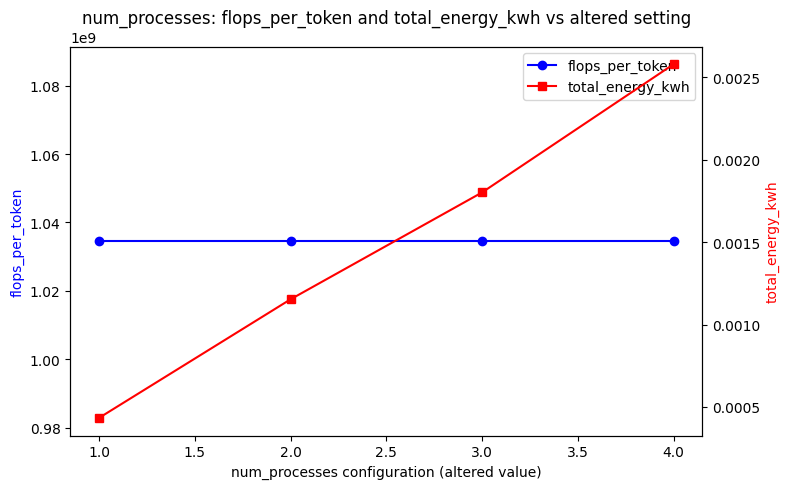

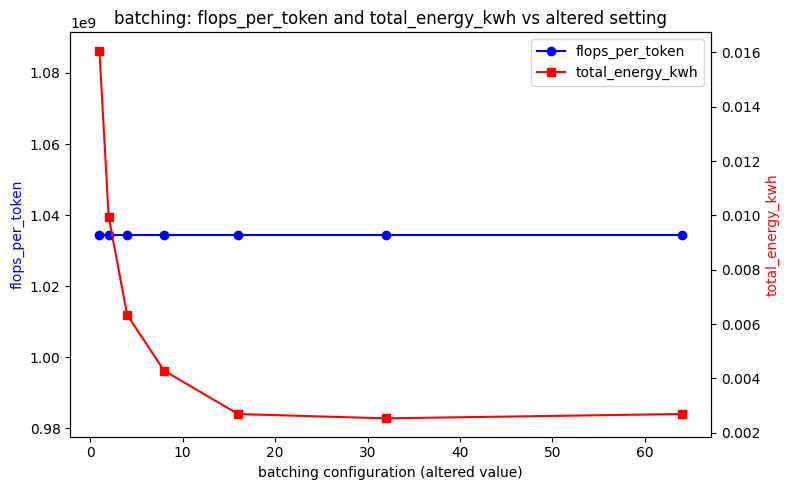

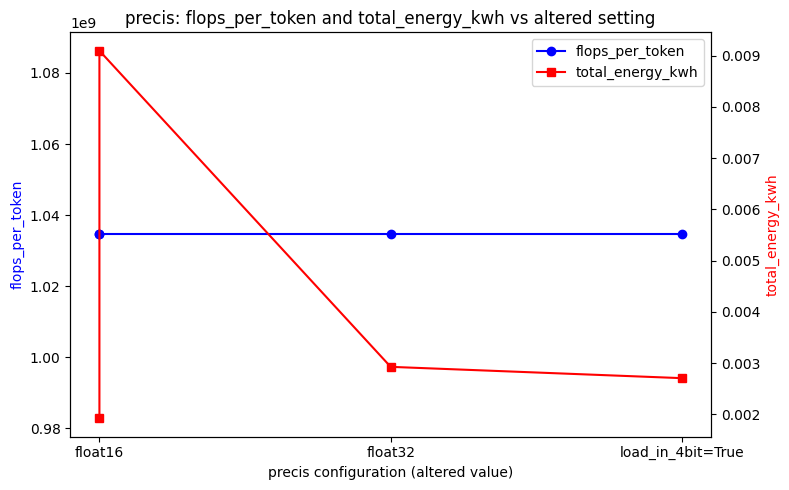

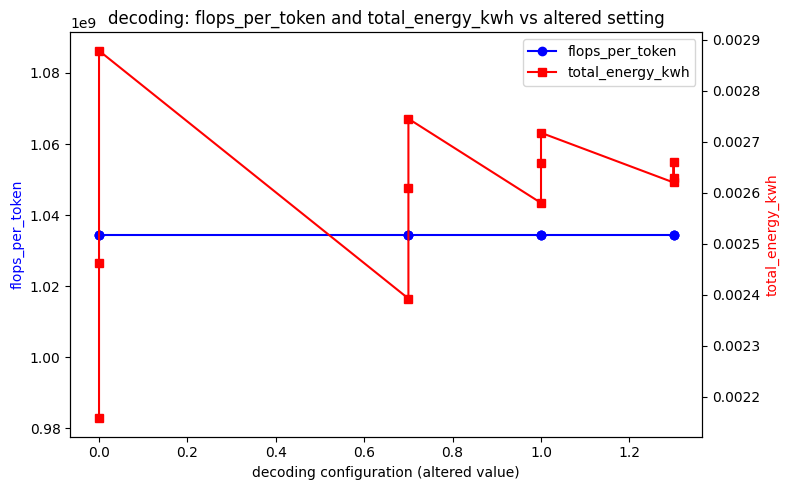

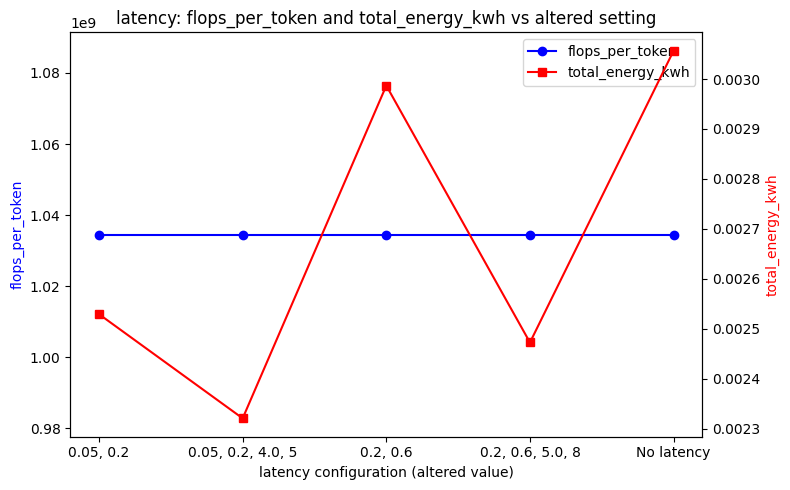

In [ ]:
import matplotlib.pyplot as plt

def extract_altered_value(config_name, family):
    """
    Given a config name and a family, extract the altered value.
    For each family, a different rule is applied:
    
    - num_processes: extract the integer after "num_processes_"
    - batching: extract the integer after "batching_"
    - precis: extract the precision setting; if quant4 is True, return "load_in_4bit=True",
              otherwise return the float precision (e.g., "float32" or "float16")
    - decoding: extract the decoder_temperature (as a float) from the config name.
    - latency: if the config is exactly "latency_False", return "No latency"; otherwise, 
               extract and join all numeric values in the config string.
    """
    if family == "num_processes":
        m = re.search(r'num_processes_(\d+)', config_name)
        return int(m.group(1)) if m else config_name
    
    elif family == "batching":
        m = re.search(r'batching_(\d+)', config_name)
        return int(m.group(1)) if m else config_name
    
    elif family == "precis":
        m = re.search(r'precis_(float\d+)', config_name)
        precision = m.group(1) if m else None
        # If quant4 is True, we assume load_in_4bit is the relevant setting. COME BACK TO THIS!!!
        if "quant4_True" in config_name:
            return "load_in_4bit=True"
        else:
            return precision
        
    elif family == "decoding":
        # This family might have several variants. We extract the decoder_temperature. COME BACK TO
        m = re.search(r'decoder_temperature_([\d\.]+)', config_name)
        return float(m.group(1)) if m else config_name
    
    elif family == "latency":
        # If it's simply "latency_False", nothing was altered.
        if config_name == "latency_False":
            return "No latency"
        else:
            # Find all numbers (either integer or float) in the string.
            numbers = re.findall(r'\d+\.\d+|\d+', config_name)
            return ", ".join(numbers)
    else:
        return config_name

def plot_family(df, family, metric1, metric2):
    """
    For a given family, subset the DataFrame (rows whose config_name starts with family).
    Create a new column that holds the altered value for that family, sort the data by that value,
    and plot two metrics against this altered value.
    
    Parameters:
      - df: a DataFrame with a "config_name" column.
      - family: the family string (e.g. "num_processes", "batching", etc).
      - metric1: name of the first metric column to plot on the left Y axis (e.g., "flops_per_token").
      - metric2: name of the second metric column to plot on the right Y axis (e.g., "total_energy_kwh").
    """
    # Subset rows where config_name starts with the family string.
    df_family = df[df['config_name'].str.startswith(family)].copy()
    
    # Apply the parser to create an "altered_value" column.
    df_family['altered_value'] = df_family['config_name'].apply(lambda x: extract_altered_value(x, family))
    
    # Attempt to sort by altered_value.
    # If the values are numeric, convert them.
    try:
        df_family['altered_value'] = pd.to_numeric(df_family['altered_value'])
    except:
        pass  # leave as string if conversion fails
    
    df_family.sort_values('altered_value', inplace=True)
    
    # Create a plot with twin y-axes.
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax2 = ax1.twinx()
    
    # Plot metric1 on ax1 and metric2 on ax2.
    ax1.plot(df_family['altered_value'], df_family[metric1], marker='o', label=metric1, color='blue')
    ax2.plot(df_family['altered_value'], df_family[metric2], marker='s', label=metric2, color='red')
    
    ax1.set_xlabel(f'{family} configuration (altered value)')
    ax1.set_ylabel(metric1, color='blue')
    ax2.set_ylabel(metric2, color='red')
    plt.title(f'{family}: {metric1} and {metric2} vs altered setting')
    
    # Combine the legends.
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')
    
    plt.tight_layout()
    plt.show()


families = ["num_processes", "batching", "precis", "decoding", "latency"]

for fam in families:
    plot_family(df_controlled_dropped, fam, metric1="flops_per_token", metric2="energy_per_token_kwh")
